In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from quantities import ns, s
from neo.core import SpikeTrain
from elephant.statistics import isi, cv, mean_firing_rate
import matplotlib.pyplot as plt
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\ProgramData\Anaconda3\lib\site-packages\elephant\spade.py:82: UserWarning: fim.so not found in elephant/spade_src folder,you are using the python implementation of fast fca
  'you are using the python implementation of fast fca')


In [2]:
def load_data(recording, data_dir, verbose):
    if verbose:
        print('Loading data:\t{}'.format(recording))
    path = ''.join([os.path.join(data_dir, recording, recording), '.csv'])
    return pd.read_csv(path)


def manipulate_df(df):
    df['spike'] = 1
    df['time'] = pd.to_timedelta(df['time'], unit='s')
    return df


def create_time_series(df):
    df = df.pivot_table(index='time',
                        columns='spike_cluster',
                        values='spike',
                        aggfunc='count')
    return df


def get_condition_times(df, experiment):
    if experiment == 'DREADD':
        max_time = df[df['condition'] == 'CNO']['time'].iloc[-1].total_seconds()
        max_time = list(zip(['CNO'], [max_time]))
        n_conditions = 1
    elif experiment == 'CIT':
        max_time_cit = df[df['condition'] == 'CIT']['time'].iloc[-1].total_seconds()
        if 'WAY' in df['condition'].values:
            max_time_way = df[df['condition'] == 'WAY']['time'].iloc[-1].total_seconds()
            n_conditions = 2
        else:
            max_time_way = max_time_cit
            n_conditions = 1
        max_time = list(zip(['CIT', 'WAY'], [max_time_cit, max_time_way]))
    return max_time, n_conditions


def calculate_neuron_cov(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    cv_isis = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            plt.tight_layout()
            cv_isi = cv(isi(spike_train))
        except IndexError:
            cv_isi = np.nan
        cv_isis[ind] = cv_isi

    return cv_isis


def calculate_neuron_mfr_elephant(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            mfr = mean_firing_rate(spike_train)
        except IndexError:
            mfr = np.nan
        mfrs[ind] = mfr
    mfrs *= 10**9
    return mfrs


def make_df_stats(averaging_method, recording, cv_isis_ts,mean_firing_rates_ts):
    if averaging_method == 'mean':
        cov_medians = cv_isis_ts.apply(np.nanmean)
        mfr_medians = mean_firing_rates_ts.apply(np.nanmean)

    elif averaging_method == 'median':
        cov_medians = cv_isis_ts.apply(np.nanmedian)
        mfr_medians = mean_firing_rates_ts.apply(np.nanmedian)

    elif averaging_method == 'ruairi_old_median':
        cov_medians = get_medians(df=cv_isis_ts, lab='CV ISI')
        mfr_medians = get_medians(df=mean_firing_rates_ts, lab='Firing Rate')
    
    df_stats = pd.concat([cov_medians, mfr_medians], axis=1)
    df_stats.columns = ['CV ISI', 'Firing Rate']
    df_stats['recording'] = recording
    return df_stats


def calculate_neuron_mfr_numpy(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        num_spikes = np.sum(col_bin == 1)
        if not num_spikes:
            mfr = 0
        else:
            mfr = num_spikes/(num_mins_per_bin*60)
        mfrs[ind] = mfr
    mfrs.fillna(0, inplace=True)
    #mfrs *= 10**10
    return mfrs  #differrent from stats


def get_medians(df, lab):
    empty = np.zeros(len(df.columns))
    for col in range(len(df.columns)):
        vals = df.iloc[:, col].dropna().values
        med = np.median(vals)
        empty[col] = med
    df = pd.DataFrame({lab: empty}, index=df.columns)
    return df


def plot_cluster(dfs, max_time, experiment, df_base, recording, medians, n_conditions, labs=['Firing Rate', 'CV-ISI']):
    num_mins = np.int(max_time / 60)

    if experiment == 'CIT':
        condition_lab_1 = 'Citalopram'
        condition_lab_2 = 'WAY'

    elif experiment == 'DREADD':
        condition_lab_1 = 'CNO'

    for col in range(len(dfs[0].columns)):
        # New set of plots for each column (for each cluster)
        f, a = plt.subplots(figsize=(12, 12), nrows=3)

        for ind, df in enumerate(dfs):
            # Plot Firing rate and CV ISI over time
            x = np.linspace(0, num_mins, len(df))
            y = df.iloc[:, col]
            a[ind].plot(x, y, linewidth=1.5)

            # Plot line for median Firing rate
            line_y = np.ones(10) * medians[ind].iloc[col]
            line_x = np.linspace(1, num_mins, 10)
            a[ind].plot(line_x, line_y, linestyle='--', color='k',
                        label='Median {lab}:{num}'.format(lab=labs[ind], num=str(np.round(medians[ind].iloc[col], 2))))

            # Set condition indicators
            condition_indecator_y = (np.ones(2) * np.max(df.iloc[:, col])) + 1
            condition_indecator_x = np.linspace(60, num_mins, 2)
            a[ind].plot(condition_indecator_x, condition_indecator_y, linewidth=4, label=(condition_lab_1))

            # Indicate WAY if data from CIT experiment
            if n_conditions == 2 and experiment == 'CIT':
                condition_indecator_x = np.linspace(120, num_mins, 2)
                condition_indecator_y = (np.ones(2) * np.max(df.iloc[:, col])) + 0.3
                a[ind].plot(condition_indecator_x, condition_indecator_y, linewidth=4, label=(condition_lab_2))

            a[ind].set_title('{lab} over time.\nCluster {clus}'. format(clus=df.columns[col], lab=labs[ind]))

            # Set plot aesthetics
            a[ind].set_ylabel(labs[ind])
            a[ind].set_xlabel('Time [minutes]')
            a[ind].fill_between(x, y, alpha=0.4)
            a[ind].legend()

        if not os.path.exists(fig_folder):
            os.mkdir(fig_folder)

        spike_times = pd.to_numeric(df_base.iloc[:, col][df_base.iloc[:, col].notnull()].index.values) / 10**10
        spike_train = SpikeTrain(times=spike_times,
                                 t_stop=spike_times[-1],
                                 units=s)
        isis = isi(spike_train)
        isis = np.array(isis) * 10
        a[2].hist(isis, bins=np.int(len(isis) / 4), alpha=0.8)
        a[2].set_title('Inter Spike Interval Histogram')
        a[2].set_xlim([0, 3.5])
        a[2].set_xlabel('Time [Seconds]')
        plt.tight_layout()
        plt.show()


def mkdirs_(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [3]:
recording = '2018-05-01_01'
data_dir=r'F:\CIT_WAY\csvs\spikes_time_series'
experiment='CIT'
temp_folder=r'F:\CIT_WAY\csvs\temp'
fig_folder=r'F:\CIT_WAY\figures\cluster_over_time_test'
mfr_method = 'elephant'
averaging_method = 'mean'
verbose=True


In [4]:
df = load_data(recording=recording,
                       data_dir=data_dir,
                       verbose=verbose)
df = manipulate_df(df)

Loading data:	2018-05-01_01


In [5]:
max_times, n_conditions = get_condition_times(df=df, experiment=experiment)

In [6]:
max_times = max_times[1][1]

In [7]:
max_times

7897.218067000001

In [9]:
df_base = df[df['condition'] == 'Baseline']
df_ts = create_time_series(df_base)
cv_isis_ts = df_ts.apply(func=calculate_neuron_cov,
                                 num_mins_per_bin=2,
                                 total_time=60)
mean_firing_rates_ts = df_ts.apply(func=calculate_neuron_mfr_elephant,
                                           num_mins_per_bin=2,
                                           total_time=60)
df_stats = make_df_stats(averaging_method='mean', recording=recording, cv_isis_ts=cv_isis_ts, mean_firing_rates_ts=mean_firing_rates_ts)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:998: RuntimeWarning: Mean of empty slice.
  return a.std(axis) / a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
mean_firing_rates_ts

spike_cluster,0,4,6,9,13,16,17,22,24,26,...,74,83,97,98,99,103,112,113,116,119
0,0.080243,0.443871,0.313426,5.371978,0.164693,0.092366,0.941630,0.012747,NaN,0.019252,...,0.646032,2.367089,15.822313,0.748906,7.453208,0.046059,9.344055,1.970456,4.234174,6.804892
1,0.025256,0.376317,0.121072,2.876803,0.110838,0.028412,0.645105,NaN,0.006576,NaN,...,0.329334,1.828908,6.095690,0.524062,3.165903,0.040880,4.598279,1.012170,0.570187,3.303767
2,0.011459,0.388361,0.064586,1.598188,0.125570,0.005221,0.709162,NaN,0.006462,0.013451,...,0.153869,1.009183,4.554256,0.671707,1.840388,0.034708,2.641811,0.583197,1.269815,1.880951
3,0.033437,0.403186,0.052467,1.521527,0.014724,0.006377,0.579554,NaN,0.002114,0.011384,...,0.090590,0.885607,2.583139,0.371802,1.497915,0.026104,2.134038,0.523846,0.644161,1.545535
4,0.015135,0.429878,0.072910,1.194796,0.017546,0.005489,0.463639,NaN,0.002908,0.008884,...,0.086542,0.729040,1.972749,0.242984,1.252634,0.024180,1.657076,0.384575,0.572356,1.294971
5,0.012473,0.451779,0.057228,0.921004,0.015588,0.005354,0.329725,NaN,0.003325,0.003184,...,0.076646,0.547899,1.901647,0.177448,1.054545,0.017926,1.339529,0.339786,0.298412,1.097099
6,0.017544,0.471857,0.063566,0.646892,0.010487,0.002720,0.322669,NaN,0.005259,0.019361,...,0.109769,0.501348,1.398101,0.153292,0.937456,0.027003,1.129783,0.309887,0.114936,0.954873
7,0.029344,0.386774,0.056452,0.527331,0.029346,0.006108,0.343128,0.038377,0.001514,0.066211,...,0.077502,0.369515,0.793025,0.148246,0.782476,0.035361,0.992555,0.261083,0.097177,0.805040
8,0.096211,0.203468,0.101717,0.644051,0.164281,0.002169,0.297595,0.176008,0.275880,0.030238,...,0.028320,0.059888,0.458381,0.159460,0.548376,0.050854,0.458029,0.421269,0.690908,0.593933
9,0.130565,0.123557,0.114028,0.452837,0.222291,0.000675,0.246498,0.180919,0.110212,0.119819,...,0.035095,0.029371,0.584660,0.146523,0.449678,0.070064,0.250367,0.492310,0.541348,0.489756


In [8]:
df_ts_all = create_time_series(df)
cv_isis_ts = df_ts_all.apply(func=calculate_neuron_cov,
                                     num_mins_per_bin=2,
                                     total_time=np.int(max_times / 60))
mean_firing_rates_ts = df_ts_all.apply(func=calculate_neuron_mfr_elephant,
                                           num_mins_per_bin=2,
                                           total_time=np.int(max_times / 60))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:998: RuntimeWarning: Mean of empty slice.
  return a.std(axis) / a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
num_bins = np.int(np.int(max_times / 60) / 2)
col_bins = np.array_split(df_ts_all.loc[:,99], num_bins)
mfrs = pd.Series(np.zeros(num_bins))


In [166]:
df_ts_all.loc[:,99].index

TimedeltaIndex(['00:00:00.015833', '00:00:00.023667', '00:00:00.023767',
                '00:00:00.026600', '00:00:00.048833', '00:00:00.064000',
                '00:00:00.091900', '00:00:00.116000', '00:00:00.117467',
                '00:00:00.140900',
                ...
                '02:11:36.378700', '02:11:36.378900', '02:11:36.378933',
                '02:11:36.379067', '02:11:36.379300', '02:11:36.379333',
                '02:11:36.379633', '02:11:37.217800', '02:11:37.218033',
                '02:11:37.218067'],
               dtype='timedelta64[ns]', name='time', length=538955, freq=None)

In [33]:
spike_times = pd.to_numeric(df_ts_all.loc[:,99][df_ts_all.loc[:,99].notnull()].index.values)
spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)

In [215]:
df_ts_all.loc[:,99][df_ts_all.loc[:,99].notnull()].index.values

array([     15833000,     140900000,     264500000, ..., 7896378533000,
       7896378933000, 7896379333000], dtype='timedelta64[ns]')

In [31]:
import elephant

In [146]:
binned_train = elephant.conversion.BinnedSpikeTrain(spike_train, num_bins=num_bins)

In [147]:
cch, bins = elephant.spike_train_correlation.cch(binned_train, binned_train)

In [148]:
cch_df = pd.DataFrame(cch)


In [149]:
new_df = pd.DataFrame({'values':cch_df[0], 'bins':bins})

In [155]:
new_df.loc[65]

bins             1
values    15734304
Name: 65, dtype: int32

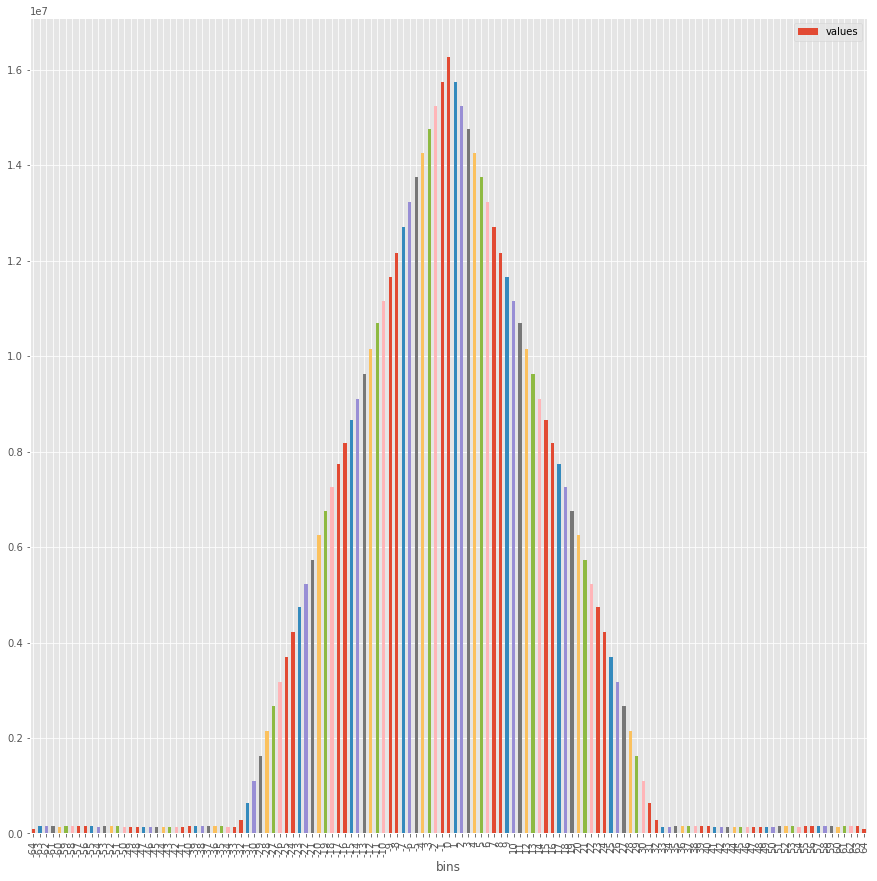

In [152]:
new_df.plot(kind='bar', x='bins', y='values', figsize = (15,15))
plt.show()

In [ ]:
plot_cluster(dfs=[mean_firing_rates_ts, cv_isis_ts],
                     max_time=max_times,
                     df_base=df_ts,
                     recording=recording,
                     experiment='CIT',
                     medians=[df_stats['Firing Rate'], df_stats['CV ISI']],
                     labs=['Firing Rate [Hz]', 'CV-ISI'],
                     n_conditions=n_conditions)

# FIXED (I GUESS)

### 1) The total time for mean_firing_rates_ts of all neurons should be max_time instead of 60

### 2) 1 s = 10^9 ns, so the function calculate_neuron_mfr_elephant  should have mfrs *= 10^9 and not 10^10



In [212]:
from statsmodels.graphics.tsaplots import plot_acf

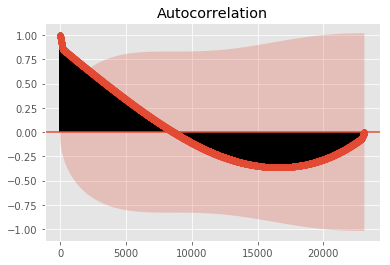

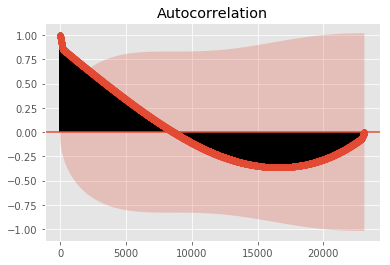

In [217]:
plot_acf(spike_times)

In [219]:

def _increment(arr, indices):
    """Increment some indices in a 1D vector of non-negative integers.
    Repeated indices are taken into account."""
    arr = _as_array(arr)
    indices = _as_array(indices)
    bbins = np.bincount(indices)
    arr[:len(bbins)] += bbins
    return arr


def _diff_shifted(arr, steps=1):
    arr = _as_array(arr)
    return arr[steps:] - arr[:len(arr) - steps]


def _create_correlograms_array(n_clusters, winsize_bins):
    return np.zeros((n_clusters, n_clusters, winsize_bins // 2 + 1),
                    dtype=np.int32)


def _symmetrize_correlograms(correlograms):
    """Return the symmetrized version of the CCG arrays."""

    n_clusters, _, n_bins = correlograms.shape
    assert n_clusters == _

    # We symmetrize c[i, j, 0].
    # This is necessary because the algorithm in correlograms()
    # is sensitive to the order of identical spikes.
    correlograms[..., 0] = np.maximum(correlograms[..., 0],
                                      correlograms[..., 0].T)

    sym = correlograms[..., 1:][..., ::-1]
    sym = np.transpose(sym, (1, 0, 2))

    return np.dstack((sym, correlograms))


def correlograms(spike_times,
                 spike_clusters,
                 cluster_ids=None,
                 sample_rate=1.,
                 bin_size=None,
                 window_size=None,
                 symmetrize=True,
                 ):
    """Compute all pairwise cross-correlograms among the clusters appearing
    in `spike_clusters`.
    Parameters
    ----------
    spike_times : array-like
        Spike times in seconds.
    spike_clusters : array-like
        Spike-cluster mapping.
    cluster_ids : array-like
        The list of unique clusters, in any order. That order will be used
        in the output array.
    bin_size : float
        Size of the bin, in seconds.
    window_size : float
        Size of the window, in seconds.
    Returns
    -------
    correlograms : array
        A `(n_clusters, n_clusters, winsize_samples)` array with all pairwise
        CCGs.
    """
    assert sample_rate > 0.
    assert np.all(np.diff(spike_times) >= 0), ("The spike times must be "
                                               "increasing.")

    # Get the spike samples.
    spike_times = np.asarray(spike_times, dtype=np.float64)
    spike_samples = (spike_times * sample_rate).astype(np.int64)

    spike_clusters = _as_array(spike_clusters)

    assert spike_samples.ndim == 1
    assert spike_samples.shape == spike_clusters.shape

    # Find `binsize`.
    bin_size = np.clip(bin_size, 1e-5, 1e5)  # in seconds
    binsize = int(sample_rate * bin_size)  # in samples
    assert binsize >= 1

    # Find `winsize_bins`.
    window_size = np.clip(window_size, 1e-5, 1e5)  # in seconds
    winsize_bins = 2 * int(.5 * window_size / bin_size) + 1

    assert winsize_bins >= 1
    assert winsize_bins % 2 == 1

    # Take the cluster oder into account.
    if cluster_ids is None:
        clusters = _unique(spike_clusters)
    else:
        clusters = _as_array(cluster_ids)
    n_clusters = len(clusters)

    # Like spike_clusters, but with 0..n_clusters-1 indices.
    spike_clusters_i = _index_of(spike_clusters, clusters)

    # Shift between the two copies of the spike trains.
    shift = 1

    # At a given shift, the mask precises which spikes have matching spikes
    # within the correlogram time window.
    mask = np.ones_like(spike_samples, dtype=np.bool)

    correlograms = _create_correlograms_array(n_clusters, winsize_bins)

    # The loop continues as long as there is at least one spike with
    # a matching spike.
    while mask[:-shift].any():
        # Number of time samples between spike i and spike i+shift.
        spike_diff = _diff_shifted(spike_samples, shift)

        # Binarize the delays between spike i and spike i+shift.
        spike_diff_b = spike_diff // binsize

        # Spikes with no matching spikes are masked.
        mask[:-shift][spike_diff_b > (winsize_bins // 2)] = False

        # Cache the masked spike delays.
        m = mask[:-shift].copy()
        d = spike_diff_b[m]

        # # Update the masks given the clusters to update.
        # m0 = np.in1d(spike_clusters[:-shift], clusters)
        # m = m & m0
        # d = spike_diff_b[m]
        d = spike_diff_b[m]

        # Find the indices in the raveled correlograms array that need
        # to be incremented, taking into account the spike clusters.
        indices = np.ravel_multi_index((spike_clusters_i[:-shift][m],
                                        spike_clusters_i[+shift:][m],
                                        d),
                                       correlograms.shape)

        # Increment the matching spikes in the correlograms array.
        _increment(correlograms.ravel(), indices)

        shift += 1

    # Remove ACG peaks.
    correlograms[np.arange(n_clusters),
                 np.arange(n_clusters),
                 0] = 0

    if symmetrize:
        return _symmetrize_correlograms(correlograms)
    else:
        return correlograms

In [ ]:
correlograms(spike_times=spike_times,
                 spike_clusters=spi,
                 cluster_ids=None,
                 sample_rate=1.,
                 bin_size=None,
                 window_size=None,
                 symmetrize=True,
                 )